## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import warnings
import os
import contextlib
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

## Загрузка данных

In [2]:
df_raw=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_work_with_cat1.csv")
df_raw=df_raw.drop('Unnamed: 0', axis=1)
df_raw

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,address,date,coord_width,coord_len,link,distance_to_Kremlin,district,metro_line,metro_distance
0,Ясенево,8.0,0.0,26.0,1700.0,0.0,евро,3174900.0,16.0,16.0,"Москва, ул. Паустовского, 8к3",13,55.599967,37.536365,https://www.avito.ru/moskva/kvartiry/kvartira-...,17.62,Ясенево,Калужско-Рижская,12
1,Улица академика Янгеля,31.0,0.0,10.0,1973.0,0.0,требует ремонта,2500000.0,12.0,1.0,"Москва, Медынская ул., 4/1",13,55.592490,37.645717,https://www.avito.ru/moskva/kvartiry/kvartira-...,17.76,Бирюлёво Западное,Серпуховско-Тимирязевская,9
2,Братиславская,25.5,0.0,14.5,1700.0,0.0,косметический,5700000.0,26.0,9.0,"ул. Люблинская, вл. 72, корп. 11",13,55.665770,37.734130,https://www.avito.ru/moskva/kvartiry/kvartira-...,11.96,Люблино,Люблинско-Дмитровская,7
3,Панфиловская,8.0,0.0,8.0,1960.0,0.0,дизайнерский,4900000.0,1.0,1.0,"Москва, ул. Маршала Конева, 2",13,55.799952,37.491889,https://www.avito.ru/moskva/kvartiry/kvartira-...,9.59,Щукино,БКЛ,6
4,Рассказовка,31.0,0.0,20.0,2012.0,0.0,косметический,3290000.0,3.0,2.0,"Москва, Новомосковский административный округ,...",13,55.647214,37.327623,https://www.avito.ru/moskva/kvartiry/kvartira-...,21.62,NaN,Солнцевская,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27971,Ростокино,5.0,5.0,75.0,2001.0,10.0,дизайнерский,42000000.0,17.0,17.0,"Москва, ул. Бажова, 24к2",118,55.836428,37.665533,https://avito.ru//moskva/kvartiry/5-k._kvartir...,9.89,Ростокино,МЦК,4
27972,Ломоносовский проспект,2.5,4.0,70.5,2008.0,15.0,евро,74000000.0,14.0,11.0,"Москва, Ломоносовский пр-т, 29к1",118,55.703611,37.516476,https://avito.ru//moskva/kvartiry/4-k._kvartir...,8.33,Раменки,Солнцевская,3
27973,Тверская,5.0,5.0,115.5,1700.0,12.5,евро,99000000.0,4.0,4.0,"Москва, Большой Палашёвский пер., 2/12",118,55.763341,37.597073,https://avito.ru//moskva/kvartiry/5-k._kvartir...,1.89,Пресненский,Замоскворецкая,0
27974,Новаторская,5.0,6.0,129.5,1700.0,7.5,евро,72900000.0,29.0,6.0,"Москва, ул. Михаила Певцова",118,55.670855,37.514228,https://avito.ru//moskva/kvartiry/6-k._kvartir...,11.10,Проспект Вернадского,БКЛ,6


In [3]:
df_raw['district'].fillna('', inplace=True)
df_raw['metro_name'].fillna('', inplace=True)

In [4]:
df_raw=df_raw.drop(index=[13855,15282], axis=0)


## Работа с категориальными признаками

Определим список категориальных признаков

In [5]:
cat_col=['district','metro_line', 'repair', 'num_rooms']

Построим графики зависмости  средней цены в категории от категориальных признаков

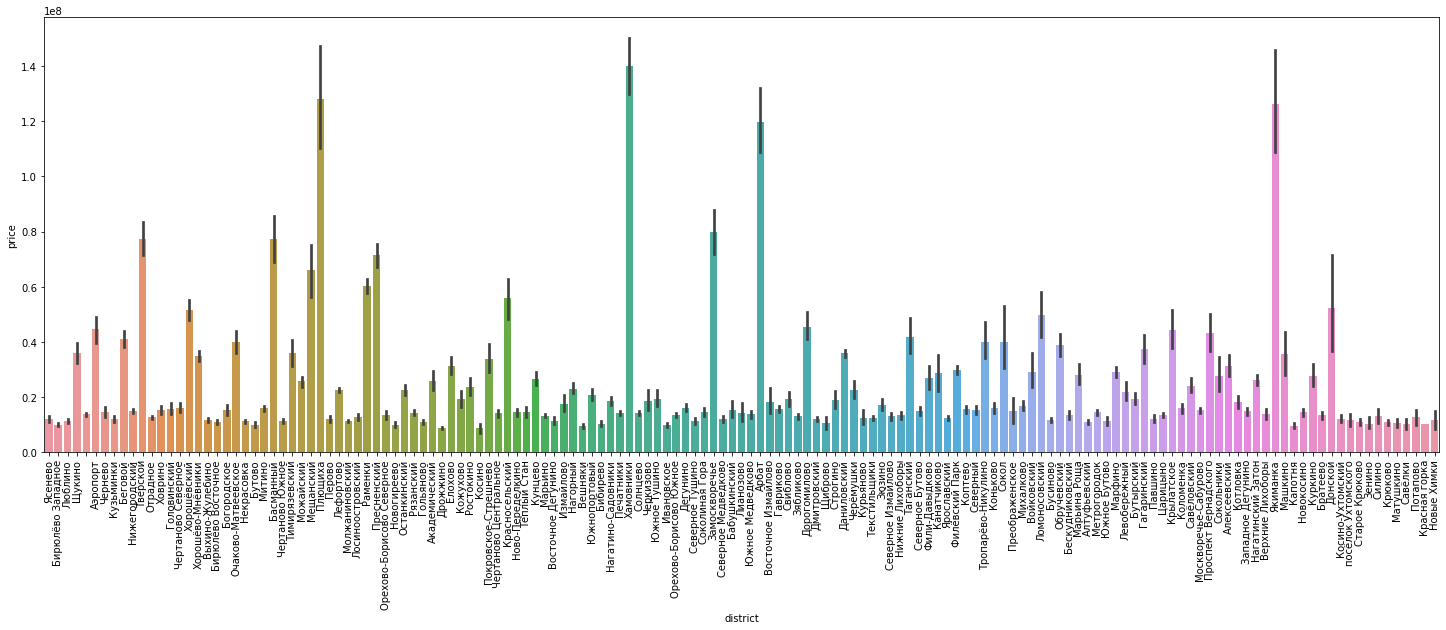

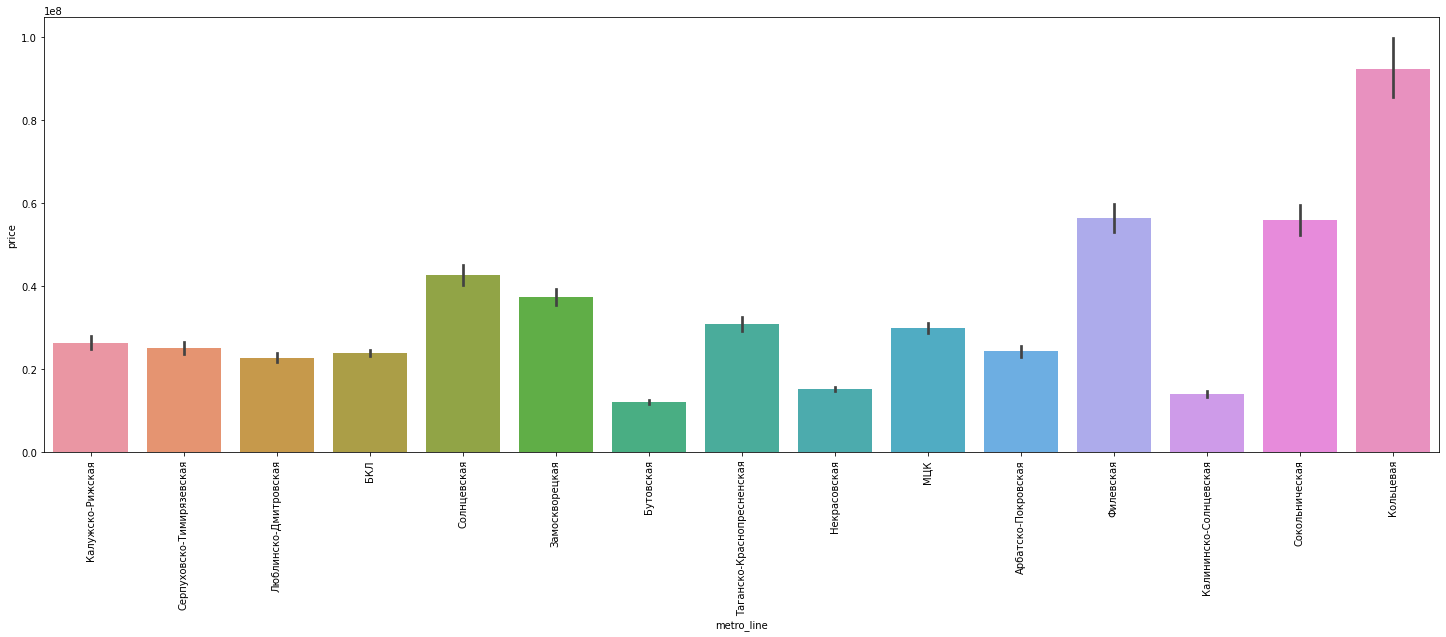

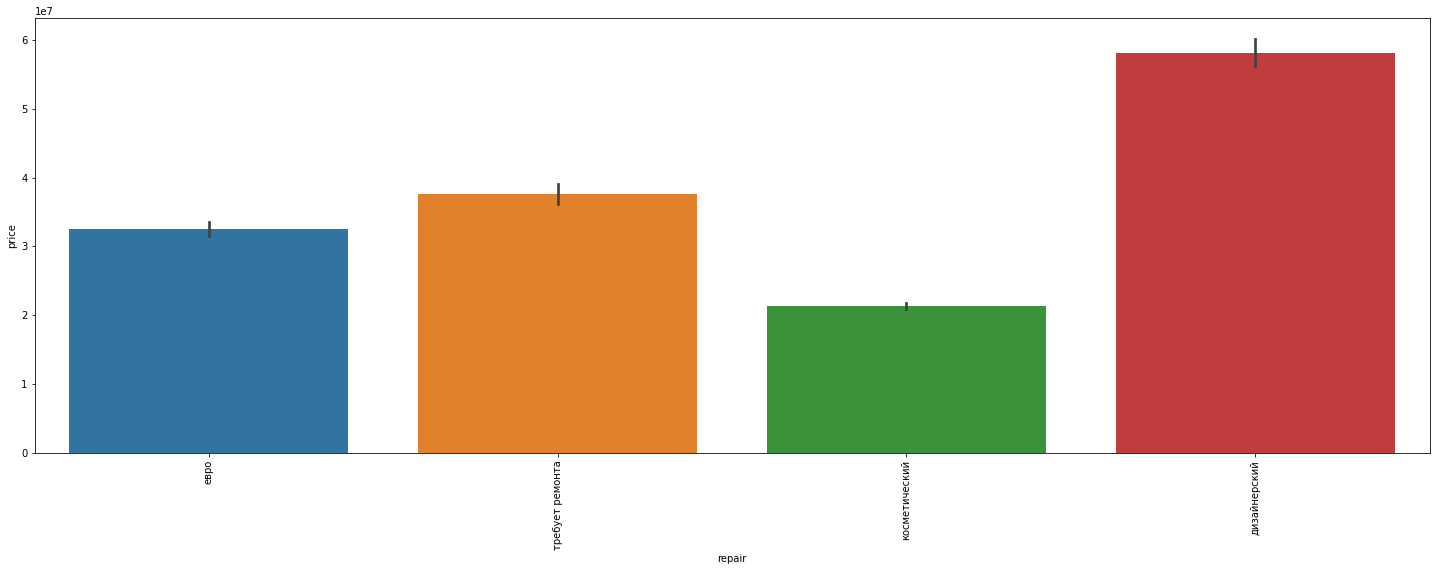

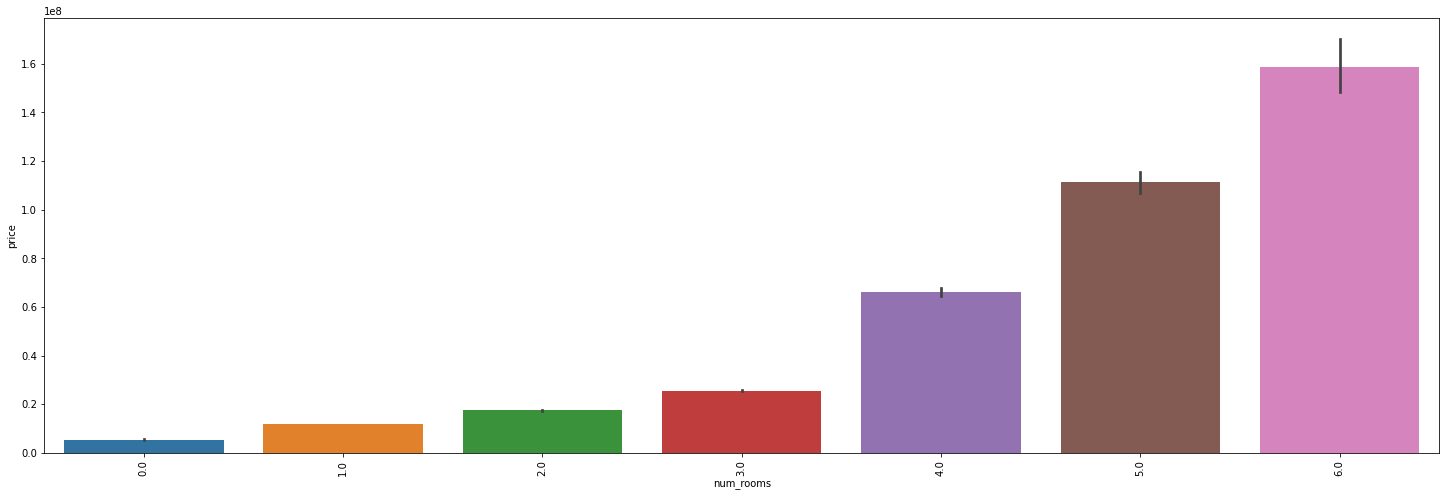

In [6]:
for i in cat_col:
    fig, axes = plt.subplots(1, figsize=(25, 8))
    for item in axes.get_xticklabels():
        item.set_rotation('vertical')
    
    sns.barplot(x=i, y='price', data=df_raw)
    plt.show()

## Кодирование признаков

Будем использовать для кодировки mean target encoding. Реализую его самостоятельно. Буду пользоваться сглаживанием. То есть кодировать будем как $(mean(target)* nrows+globalmean* \alpha)/(nrows+\alpha)$. Однако как мы можем видеть, этой формуле сопоставима другая: $k*mean(target)+(1-k)*globalmean$, где k можно выбрать глобально. Чем меньше k, тем меньше модель склонна к переобучению, но и тем меньше качество кодировки. Также я буду "обучать" TargetEncoder не на всех данных, нетроннутой я оставлю отложенную выборку.

In [7]:
class TargetEncoder():
    def __init__(self, k,  cat_features):
        self.cat_features= cat_features
        self.k=k
    def fit(self, data, y,):
        self.globalmean=np.mean(data[y])
        self.mean=[]
        for i in self.cat_features:
            self.mean.append(data.groupby(i).mean()[y])
            
    def transform(self,data):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for i in range(len(self.cat_features)):
                for j in data[self.cat_features[i]].unique():
                    try:
                        data.loc[data[self.cat_features[i]]==j, self.cat_features[i]]=(self.mean[i][j]*self.k+(1-self.k)*self.globalmean)
                    except:
                        data.loc[data[self.cat_features[i]]==j, self.cat_features[i]]=self.globalmean
                data[self.cat_features[i]]= data[self.cat_features[i]].astype('float')
        return data
        

Протестируем на синтетическом датасете

In [8]:
df_s=pd.DataFrame(columns=['x','y'])
df_s['x']=[1,0,1,0, 1, 0]
df_s['y']=[1,2,3,4,5,6]
te=TargetEncoder(0.75, ['x'])
te.fit(df_s,'y')
te.transform(df_s)

,x,y
0,3.125,1
1,3.875,2
2,3.125,3
3,3.875,4
4,3.125,5
5,3.875,6


Тест прошел успешно

Разобьем наши данные на обучающую и отложенную выборку

In [9]:
df_mte_tr, df_mte_val=train_test_split(df_raw, test_size=0.5, random_state=42, shuffle=True)
mte=TargetEncoder(k=0.8, cat_features=cat_col)
mte.fit(df_mte_tr, 'price' )
df_mte_tr=mte.transform(df_mte_tr)
df_mte_val=mte.transform(df_mte_val)
df_mte=mte.transform(df_raw)

In [10]:
df_mte.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27974 entries, 0 to 27975
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   metro_name           27974 non-null  object 
 1   time_to_metro        27974 non-null  float64
 2   num_rooms            27974 non-null  float64
 3   total_area           27974 non-null  float64
 4   year_house           27974 non-null  float64
 5   kitchen_area         27974 non-null  float64
 6   repair               27974 non-null  float64
 7   price                27974 non-null  float64
 8   floors               27974 non-null  float64
 9   num_floor            27974 non-null  float64
 10  address              27974 non-null  object 
 11  date                 27974 non-null  int64  
 12  coord_width          27974 non-null  float64
 13  coord_len            27974 non-null  float64
 14  link                 27974 non-null  object 
 15  distance_to_Kremlin  27974 non-null 

Посмотрим на коррреляцию наших признаков с нашим целевым признаком после mte кодировки

In [11]:
df_mte.drop(['coord_width', 'coord_len'], axis=1).corr()['price']

time_to_metro         -0.025682
num_rooms              0.702415
total_area             0.853662
year_house            -0.048710
kitchen_area           0.509221
repair                 0.290656
price                  1.000000
floors                 0.044400
num_floor              0.085265
date                  -0.261587
distance_to_Kremlin   -0.393354
district               0.604216
metro_line             0.341803
metro_distance        -0.328481
Name: price, dtype: float64

Также создадим датасет с Label encoding и посмотрим, что лучше

In [12]:

df_le=df_raw.copy()

for i in cat_col:
    le=LabelEncoder()
    df_le[i]=le.fit_transform(df_le[i])

df_le_tr, df_le_val=train_test_split(df_raw, test_size=0.5, random_state=42, shuffle=True)
df_le_val.sample(5)

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,address,date,coord_width,coord_len,link,distance_to_Kremlin,district,metro_line,metro_distance
10735,Новаторская,7.5,2.651027e+07,40.0,1957.0,6.5,5.234562e+07,27500000.0,8.0,5.0,"Москва, Ленинский проспект, 86",135,55.676768,37.527507,https://avito.ru//moskva/kvartiry/3-k._kvartir...,10.08,5.169805e+07,2.497894e+07,6
20151,Отрадное,5.0,1.555949e+07,16.5,1975.0,3.0,2.299117e+07,10500000.0,9.0,5.0,"Москва, улица Пестеля, 8",128,55.866177,37.614426,https://avito.ru//moskva/kvartiry/1-k._kvartir...,12.76,1.593984e+07,2.633074e+07,10
891,Люблино,5.0,1.027881e+07,15.0,1971.0,0.0,3.142662e+07,3700000.0,9.0,1.0,"Москва, Новороссийская ул., 12",33,55.678945,37.758401,https://www.avito.ru/moskva/kvartiry/kvartira-...,11.89,1.447535e+07,2.451582e+07,6
23584,Рассказовка,10.0,2.651027e+07,41.5,1700.0,10.5,2.299117e+07,16727200.0,22.0,9.0,"пос. Внуковское, дер. Рассказовка, б-р Андрея ...",127,55.624040,37.341370,https://avito.ru//moskva/kvartiry/3-k._kvartir...,22.43,1.670149e+07,3.904804e+07,11
16131,Нагорная,2.5,5.852692e+07,50.0,1700.0,7.0,2.299117e+07,35462882.0,5.0,3.0,"пр-д Электролитный , вл. 7А, корп. 6",129,55.672960,37.607690,https://avito.ru//moskva/kvartiry/4-k._kvartir...,8.76,2.073439e+07,2.633074e+07,3


## Выбор кодировки

Создадим матрицу признаков и вектор целевой переменной, удалив все ненужные признаки.

In [13]:
X_le, y_le=df_le_val.drop(['metro_name','price','address','coord_width', 'coord_len', 'link', 'date'], axis=1), df_le_val['price']
X_mte, y_mte=df_mte_val.drop(['metro_name','price','address','coord_width', 'coord_len', 'link', 'date'], axis=1), df_mte_val['price']

Проверим какая кодировка лучше, используя LGBMRegressor. Будем использовать GridsearchCV для подбора лучших гиперпараметров. После того как "потюним" модель, обучим модель на обучаюшей выборке и проверим ее на валидационной. Выберем кодировку с меньшей ошибкой

In [14]:
def get_best_params(X,y, gbm, param_grid):
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        
        gd=GridSearchCV(gbm, param_grid, cv=5, scoring='neg_mean_absolute_percentage_error',verbose=-1 )
        gd.fit(X, y)
        
    return gd.best_params_


def get_mape(X,y, gbm):
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    errors=[]
    
    with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
        
        for tr_ind, val_ind in skf.split(X, y):
            
            gb=gbm
            
            gb.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
            
            errors.append(mape(y.iloc[val_ind],gb.predict(X.iloc[val_ind,:])))
            
    return np.mean(errors)

In [15]:
param_grid={ 'lambda_l1':[1,5,15,30], 'learning_rate':[0.1, 0.2, 0.3],
                         'n_estimators':[1000, 2000, 4000]}

lgbm=LGBMRegressor(verbose=-1, random_state=42, bagging_fraction=0.5)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_params=get_best_params(X_le,y_le,lgbm,param_grid)

    lgbmb=LGBMRegressor(verbose=-1, random_state=42, bagging_fraction=0.5,**best_params)

    print(f'MAPE for le encoding for lightgbm: {get_mape(X_le,y_le,lgbmb)}')

MAPE for le encoding for lightgbm: 0.16345469004684332


In [16]:
lgbm=LGBMRegressor(verbose=-1, random_state=42, bagging_fraction=0.5)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_params=get_best_params(X_mte,y_mte,lgbm,param_grid)

    lgbmb=LGBMRegressor(verbose=-1, random_state=42, bagging_fraction=0.5,**best_params)

    print(f'MAPE for mte encoding for lightgbm: {get_mape(X_mte,y_mte,lgbmb)}')

MAPE for mte encoding for lightgbm: 0.16345469004684332


In [17]:
xg=XGBRegressor()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_params=get_best_params(X_le,y_le,lgbm,param_grid)

    xg1=XGBRegressor( random_state=42,**best_params)

    print(f'MAPE for le encoding for xgboost: {get_mape(X_le,y_le,xg1)}')

MAPE for le encoding for xgboost: 0.16323591878715654


In [18]:
xg=XGBRegressor()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_params=get_best_params(X_mte,y_mte,xg,param_grid)

    xg2=xg=XGBRegressor(random_state=42, **best_params)

    print(f'MAPE for mte encoding for xgboost: {get_mape(X_mte,y_mte,xg2)}')

MAPE for mte encoding for xgboost: 0.16323591878715654


mte лучше для xgboost, le лучше для lightgbm

## Сохранение данных

In [19]:
df_le.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_encoding_le.csv")
df_mte.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_encoding_mte.csv")